In [ ]:
# Importar e instalar dependencias
import pandas as pd
import numpy as np
import re
from collections import Counter

# CARGA DE DATOS

In [ ]:
!pip install gdown
# Descarga el archivo del dataset de drive usando gdown
url = 'https://drive.google.com/file/d/1LkEJ3rstkdyhUGWi9O2YKQMe0wC_ZyDd/view?usp=sharing'
file_id = url.split('/')[-2]
!gdown --id $file_id

# Carga el dataset usando pandas
sd = pd.read_csv('/content/Suicide_Detection.csv')

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1LkEJ3rstkdyhUGWi9O2YKQMe0wC_ZyDd
From (redirected): https://drive.google.com/uc?id=1LkEJ3rstkdyhUGWi9O2YKQMe0wC_ZyDd&confirm=t&uuid=0de40567-2406-481c-921b-9307dea9a2e1
To: /content/Suicide_Detection.csv
100% 167M/167M [00:01<00:00, 164MB/s]


In [ ]:
# Sampleo de data para agilizar el testeo del código
sd = sd.sample(n=50000, random_state=42)

# MODELADO, ENTRENAMIENTO Y EVALUACIÓN

In [ ]:
#Copia del dataset limpio (pre_processed)
pre_processed = sd.copy()

In [ ]:
from sklearn.model_selection import train_test_split

# Separación de dataset en training y testing
train_data ,test_data = train_test_split(pre_processed,test_size=0.2,random_state=10)

print('Training data: ',len(train_data))
print('Testing data: ',len(test_data))


Training data:  40000
Testing data:  10000


### Modelo de regresión logística basado en TFIDF

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, classification_report, recall_score, f1_score, confusion_matrix,  classification_report
import pandas as pd

# TF-IDF
vectorizer_tfidf = TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2))
X_tfidf_train = vectorizer_tfidf.fit_transform(train_data['text'])
X_tfidf_test = vectorizer_tfidf.transform(test_data['text'])

In [ ]:
# Entrenamiento del modelo
model = LogisticRegression(penalty='l2', C=10, solver='saga', max_iter=200)
model.fit(X_tfidf_train, train_data['class'])

# Evaluación del modelo
predictions_tfidf = model.predict(X_tfidf_test)
accuracy_tfidf = accuracy_score(test_data['class'], predictions_tfidf)
precision_tfidf = precision_score(test_data['class'], predictions_tfidf, average='weighted')
recall_tfidf = recall_score(test_data['class'], predictions_tfidf, average='weighted')
f1_tfidf = f1_score(test_data['class'], predictions_tfidf, average='weighted')
confusion_mat_tfidf = confusion_matrix(test_data['class'], predictions_tfidf)

print(classification_report(test_data['class'], predictions_tfidf))

print("Accuracy:", accuracy_tfidf)
print("Precision:", precision_tfidf)
print("Recall:", recall_tfidf)
print("F1-Score:", f1_tfidf)
print("Confusion Matrix:\n", confusion_mat_tfidf)

              precision    recall  f1-score   support

 non-suicide       0.93      0.95      0.94      5083
     suicide       0.95      0.93      0.94      4917

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

Accuracy: 0.9377
Precision: 0.9378646661355852
Recall: 0.9377
F1-Score: 0.9376827260393893
Confusion Matrix:
 [[4823  260]
 [ 363 4554]]


In [ ]:
print("Número de características en TF-IDF:", X_tfidf_train.shape[1])

##Modelo LSTM y entrenamiento

In [ ]:
from keras.layers import Dropout, Bidirectional
from keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
# Separación de dataset en training y testing
train_data ,test_data = train_test_split(pre_processed,test_size=0.2,random_state=42)

# Preparación de datos
tokenizer= Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data['text'])
sequences = tokenizer.texts_to_sequences(train_data['text'])
X_train = pad_sequences(sequences, maxlen=100)
y_train = np.array([1 if label == 'suicide' else 0 for label in train_data['class'].values])

In [ ]:
# Construcción del modelo LSTM
model_lstm = Sequential()
model_lstm.add(Embedding(5000,64))
model_lstm.add(Bidirectional(LSTM(50, return_sequences=True)))
model_lstm.add(Dropout(0.5))
model_lstm.add(Bidirectional(LSTM(50)))
model_lstm.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))


# Compilar el modelo
# model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])

# Mostrar el resumen del modelo
model_lstm.summary()

# Entrenamiento del modelo
model_lstm.fit(X_train, y_train, epochs=5, batch_size=64)

# Evaluación LSTM
# Preparar datos de prueba
sequences_test = tokenizer.texts_to_sequences(test_data['text'])
X_test = pad_sequences(sequences_test, maxlen=100)
y_test = np.array([1 if label == 'suicide' else 0 for label in test_data['class'].values])

# Realizar predicciones
y_pred_lstm = (model_lstm.predict(X_test) > 0.5).astype("int32")

# Calcular métricas
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
precision_lstm, recall_lstm, f1_lstm, _ = precision_recall_fscore_support(y_test, y_pred_lstm, average='binary')
cm_lstm = confusion_matrix(y_test, y_pred_lstm)

print("Accuracy:", accuracy_lstm)
print("Precision:", precision_lstm)
print("Recall:", recall_lstm)
print("F1-score:", f1_lstm)
print("Confusion Matrix:\n", cm_lstm)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.8418 - loss: 0.3940
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.9202 - loss: 0.2293
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 33ms/step - accuracy: 0.9333 - loss: 0.1924
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.9367 - loss: 0.1849
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9373 - loss: 0.1784
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Accuracy: 0.9267
Precision: 0.9309572301425662
Recall: 0.9206445115810675
F1-score: 0.9257721518987342
Confusion Matrix:
 [[4696  339]
 [ 394 4571]]


## Modelo DistilBERT

In [ ]:
!pip install transformers torch evaluate
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.preprocessing import LabelEncoder
import evaluate
from datasets import load_dataset


# Cargar el tokenizador y el modelo DistilBERT para clasificación
tokenizer_bert = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', clean_up_tokenization_spaces=True)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Crear un encoder para las etiquetas
label_encoder = LabelEncoder()

# Ajustar el encoder a las etiquetas y transformar
train_data['class'] = label_encoder.fit_transform(train_data['class'])
test_data['class'] = label_encoder.transform(test_data['class'])

# Convertir las etiquetas a tensores
train_labels = torch.tensor(train_data['class'].values)
test_labels = torch.tensor(test_data['class'].values)

def encode_data(text, tokenizer):
    return tokenizer.batch_encode_plus(
        text,
        add_special_tokens=True,
        max_length=100,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

# Tokenizar los conjuntos de entrenamiento y prueba
train_encodings = encode_data(train_data['text'], tokenizer_bert)
test_encodings = encode_data(test_data['text'], tokenizer_bert)

# Crear un Dataset personalizado para el Trainer
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, train_labels)
test_dataset = CustomDataset(test_encodings, test_labels)


INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.9 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Configurar argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir='./results',          # Directorio de salida
    num_train_epochs=5,              # Número de épocas
    per_device_train_batch_size=8,   # Tamaño del batch
    gradient_accumulation_steps=8,   # Acumulación de gradientes
    fp16=True,                       # Usar precisión mixta (float16)
    logging_dir='./logs',            # Directorio de logs
    logging_steps=10,
)

# Define the compute_metrics function
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = evaluate.load("f1")
  return f1.compute(predictions=preds, references=labels)

# Entrenador
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    compute_metrics=compute_metrics
)

# Entrenar el modelo
trainer.train()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Evaluate the model
trainer.evaluate(eval_dataset=test_dataset)
predictions = trainer.predict(CustomDataset(test_encodings, test_labels))

# Obtener las etiquetas predichas
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Calcular métricas
accuracy_bert = accuracy_score(test_labels, predicted_labels)
precision_bert = precision_score(test_labels, predicted_labels, average='weighted')
recall_bert = recall_score(test_labels, predicted_labels, average='weighted')
f1_bert = f1_score(test_labels, predicted_labels, average='weighted')
cm_bert = confusion_matrix(test_labels, predicted_labels)

# Imprimir los resultados
print(f"Accuracy: {accuracy_bert}")
print(f"Precision: {precision_bert}")
print(f"Recall: {recall_bert}")
print(f"F1-score: {f1_bert}")
print(f"Confusion Matrix:\n{cm_bert}")


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss
10,0.571500
20,0.344400
30,0.224600
40,0.240700
50,0.187000
60,0.169300
70,0.178900
80,0.162400
90,0.224300
100,0.123900


Accuracy: 0.9675
Precision: 0.9675005978421838
Recall: 0.9675
F1-score: 0.9674998248146134
Confusion Matrix:
[[4876  159]
 [ 166 4799]]


#COMPARATIVA DE MÉTRICAS

In [ ]:
data = {
    'Model': ['Logistic Regression (TF-IDF)', 'LSTM', 'BERT'],
    'Accuracy': [accuracy_tfidf,  accuracy_lstm, accuracy_bert],
    'Precision': [precision_tfidf,  precision_lstm, precision_bert],
    'Recall': [recall_tfidf, recall_lstm, recall_bert],
    'F1-Score': [f1_tfidf,  f1_lstm, f1_bert]
}

df = pd.DataFrame(data)
df = df.round(3)
print(df)


                          Model  Accuracy  Precision  Recall  F1-Score
0  Logistic Regression (TF-IDF)     0.938      0.938   0.938     0.938
1                          LSTM     0.927      0.931   0.921     0.926
2                          BERT     0.968      0.968   0.968     0.967


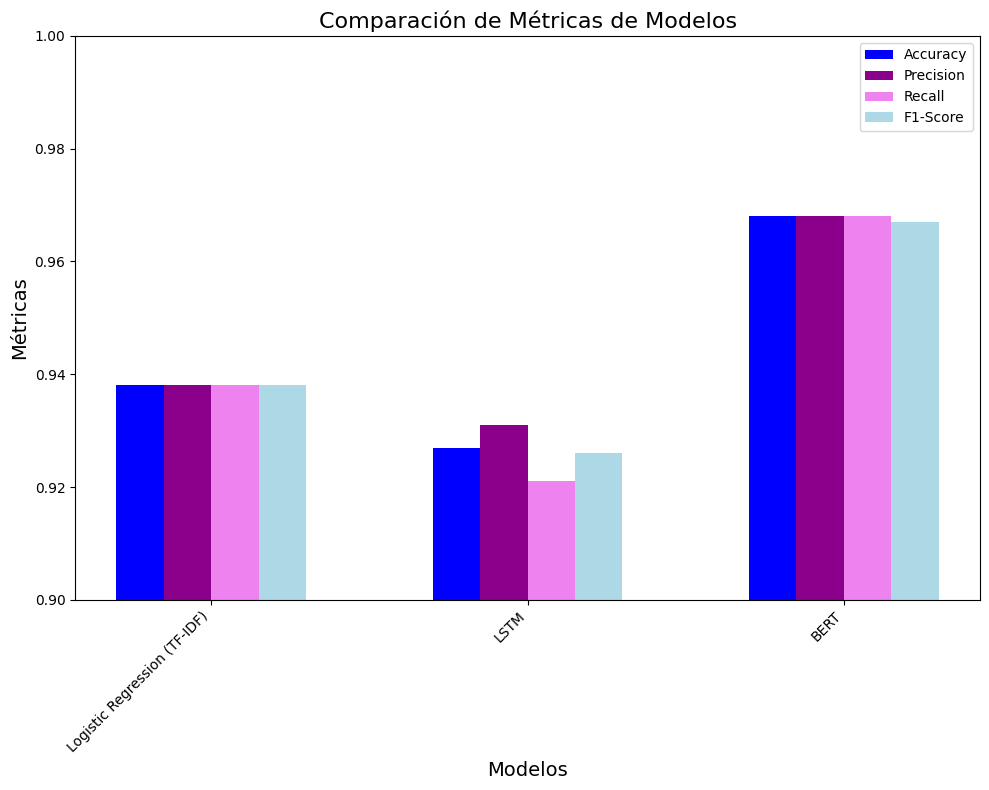

In [ ]:
# Librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns
# Crear un gráfico de barras para comparar las métricas de los modelos
plt.figure(figsize=(10, 8))

# Definir el ancho de las barras
bar_width = 0.15

# Definir las posiciones de las barras en el eje x
x = np.arange(len(df['Model']))

# Graficar las métricas
plt.bar(x - 1.5 * bar_width, df['Accuracy'], width=bar_width, label='Accuracy', color='blue')
plt.bar(x - 0.5 * bar_width, df['Precision'], width=bar_width, label='Precision', color='#8B008B')
plt.bar(x + 0.5 * bar_width, df['Recall'], width=bar_width, label='Recall', color='violet')
plt.bar(x + 1.5 * bar_width, df['F1-Score'], width=bar_width, label='F1-Score', color='lightblue')

# Etiquetas de los ejes
plt.xlabel('Modelos', fontsize=14)
plt.ylabel('Métricas', fontsize=14)
plt.ylim(0.9, 1)
plt.title('Comparación de Métricas de Modelos', fontsize=16)

# Configurar las etiquetas del eje x
plt.xticks(x, df['Model'], rotation=45, ha='right')

# Agregar una leyenda
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()